In [1]:
# Problem Statement
'''Farmers who grow potatoes suffer from serious financial standpoint losses each year which cause several diseases that affect potato plants. The diseases Early Blight and Late Blight are the most frequent. Early blight is caused by fungus and late blight is caused by specific micro-organisms and if farmers detect this disease early and apply appropriate treatment then it can save a lot of waste and prevent economical loss. The treatments for early blight and late blight are a little different so it’s important that you accurately identify what kind of disease is there in that potato plant. Behind the scene, we are going to use Convolutional Neural Network – Deep Learning to diagnose plant diseases.'''

'Farmers who grow potatoes suffer from serious financial standpoint losses each year which cause several diseases that affect potato plants. The diseases Early Blight and Late Blight are the most frequent. Early blight is caused by fungus and late blight is caused by specific micro-organisms and if farmers detect this disease early and apply appropriate treatment then it can save a lot of waste and prevent economical loss. The treatments for early blight and late blight are a little different so it’s important that you accurately identify what kind of disease is there in that potato plant. Behind the scene, we are going to use Convolutional Neural Network – Deep Learning to diagnose plant diseases.'

In [6]:
# Dataset and Colab Sheet

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import tensorflow as tf
import sklearn as sk
import os
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn import over_sampling
from imblearn.over_sampling import SMOTE
from urllib.request import urlretrieve
%matplotlib inline

ModuleNotFoundError: No module named 'imblearn'

In [7]:
#PARAMETERS
FILE_PATH = "Dataset"
IMAGE_SIZE = 256 
CHANNELS = 3
EPOCHS = 50
BATCH_SIZE= 32

Loading the dataset.

In [8]:
# oading the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
FILE_PATH,
shuffle = True,                                                                                                                                                                           
image_size =(IMAGE_SIZE,IMAGE_SIZE),
batch_size = BATCH_SIZE,
)

Found 2152 files belonging to 3 classes.


In [9]:
# let's check if correct classes are imported
classes=dataset.class_names
classes

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [10]:
len(dataset)

68

In [11]:
dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Let's plot our dataset images with their titles.

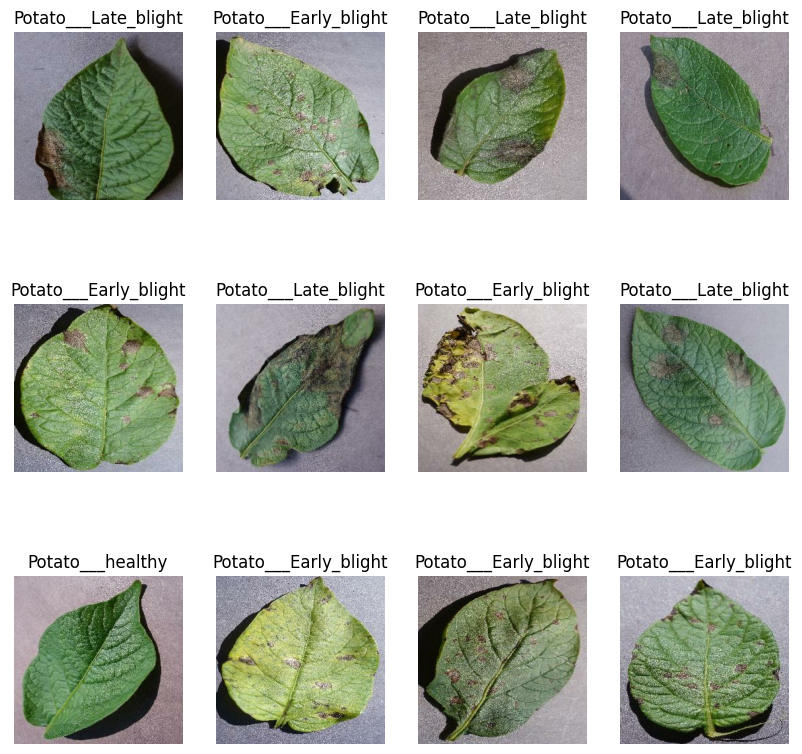

In [13]:
# plot some images from the dataset
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(classes[label_batch[i]],color='black')
        plt.axis("off")

### Splitting Database to Train, Test and Validation sets.

In [14]:
def split_data(dataset,train_split, test_split, val_split, shuffle, shuffle_size):
    assert(train_split+test_split+val_split)==1
    ds_size=len(dataset)
    
    if shuffle:
        dataset=dataset.shuffle(shuffle_size,seed=12)
    
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    
    train_ds=dataset.take(train_size)
    val_ds=dataset.skip(train_size).take(val_size)
    test_ds=dataset.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
# def split_data(dataset,train_split, test_split, val_split, shuffle, shuffle_size):   standard function to implement data split
train_df, val_df, test_df=split_data(dataset, 0.8, 0.1, 0.1, True, 1000)

In [16]:
len(train_df)

54

In [17]:
len(test_df)

8

In [18]:
len(val_df)

6

In [19]:
train_df = train_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_df = val_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_df = test_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Let's create our model

(we will be using TensorFlow for the model creation)

### Creating layers for our Resizing and Regularization

In [20]:
resize_rescale=keras.Sequential([
    keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    keras.layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation

Let's augment our data to ensure enough training examples of all kinds.

In [21]:
data_augmentation=keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
train_df

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [23]:
train_df=train_df.map(
    lambda x,y:(data_augmentation(x,training=True),y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## MODEL ARCHITECTURE

Let's create our model architecture

In [24]:
def get_model():
    input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
    n_classes=3

    Disease_Classifier=tf.keras.models.Sequential([
        resize_rescale,
        keras.layers.Conv2D(32,kernel_size=(3,3), activation='relu',input_shape=input_shape),
        keras.layers.MaxPooling2D((2,2)),
        keras.layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
        keras.layers.MaxPooling2D((2,2)),
        keras.layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
        keras.layers.MaxPooling2D((2,2)),
        keras.layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
        keras.layers.MaxPooling2D((2,2)),
        keras.layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
        keras.layers.MaxPooling2D((2,2)),
        keras.layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
        keras.layers.MaxPooling2D((2,2)),
        keras.layers.Flatten(),
        keras.layers.Dense(64,activation='relu'),
        keras.layers.Dense(n_classes, activation='softmax'),
    ])
    
    Disease_Classifier.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
    )
    
    return Disease_Classifier

In [27]:
# Disease_Classifier.build(input_shape=input_shape)

In [28]:
# Using GPU for the computation
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [30]:
with tf.device('/GPU:0'):
    Disease_Classifier=get_model()
    result=Disease_Classifier.fit(train_df,batch_size=BATCH_SIZE,validation_data=val_df,verbose=1,epochs=50)

Epoch 1/50
54/54 [==============================] - 18s 162ms/step - loss: 0.8958 - accuracy: 0.5145 - val_loss: 0.8277 - val_accuracy: 0.6250
Epoch 2/50
54/54 [==============================] - 8s 143ms/step - loss: 0.6724 - accuracy: 0.7043 - val_loss: 0.6010 - val_accuracy: 0.7344
Epoch 3/50
54/54 [==============================] - 7s 132ms/step - loss: 0.4349 - accuracy: 0.8235 - val_loss: 0.5614 - val_accuracy: 0.7604
Epoch 4/50
54/54 [==============================] - 7s 133ms/step - loss: 0.3617 - accuracy: 0.8536 - val_loss: 0.3030 - val_accuracy: 0.8854
Epoch 5/50
54/54 [==============================] - 7s 133ms/step - loss: 0.2873 - accuracy: 0.8918 - val_loss: 0.2615 - val_accuracy: 0.8802
Epoch 6/50
54/54 [==============================] - 7s 133ms/step - loss: 0.2853 - accuracy: 0.8883 - val_loss: 0.3795 - val_accuracy: 0.8125
Epoch 7/50
54/54 [==============================] - 7s 133ms/step - loss: 0.2674 - accuracy: 0.8918 - val_loss: 0.2791 - val_accuracy: 0.8906
Epoch

In [31]:
Disease_Classifier.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)       

In [32]:
scores=Disease_Classifier.evaluate(test_df)

8/8 [==============================] - 2s 38ms/step - loss: 0.0688 - accuracy: 0.9883


In [33]:
scores

[0.06876136362552643, 0.98828125]

In [34]:
result

In [35]:
result.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [36]:
result.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [37]:
result.history['loss'][:]

[0.8957629203796387,
 0.6723954081535339,
 0.43491098284721375,
 0.3617003262042999,
 0.28731876611709595,
 0.2852996289730072,
 0.2673744559288025,
 0.1815062314271927,
 0.1551726907491684,
 0.1743059754371643,
 0.07865434885025024,
 0.1323145031929016,
 0.08575329929590225,
 0.12929733097553253,
 0.09219472855329514,
 0.05491997301578522,
 0.03410008177161217,
 0.08419749140739441,
 0.03134388476610184,
 0.03456105664372444,
 0.04546137526631355,
 0.04988852143287659,
 0.05830516666173935,
 0.03237258642911911,
 0.03522879630327225,
 0.023982809856534004,
 0.08136482536792755,
 0.02151412144303322,
 0.03668123111128807,
 0.03937140107154846,
 0.020729366689920425,
 0.013621143996715546,
 0.07443986088037491,
 0.046672336757183075,
 0.045288752764463425,
 0.017480207607150078,
 0.008488320745527744,
 0.04349010810256004,
 0.05325022712349892,
 0.0188627690076828,
 0.013262566179037094,
 0.007909811101853848,
 0.04217635840177536,
 0.058050744235515594,
 0.03180397301912308,
 0.0152589

In [38]:
accuracy=result.history['accuracy'][:]
val_accuracy=result.history['val_accuracy'][:]
loss=result.history['loss'][:]
val_loss=result.history['val_loss'][:]

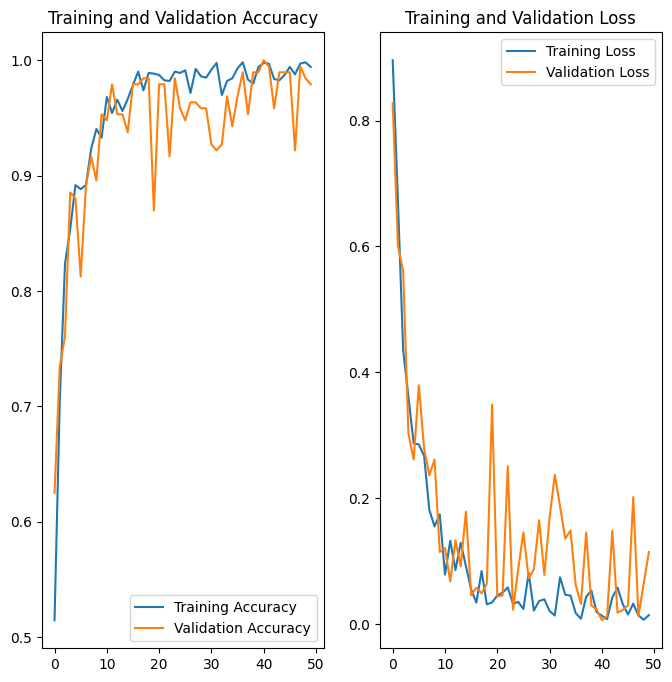

In [39]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label='Training Accuracy')
plt.plot(range(EPOCHS), val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Running prediction on Test images.

Image to be predicted
1/1 [==============================] - 0s 130ms/step
First Image
Actual Label :  Potato___Early_blight
Predicted Label :  Potato___Early_blight


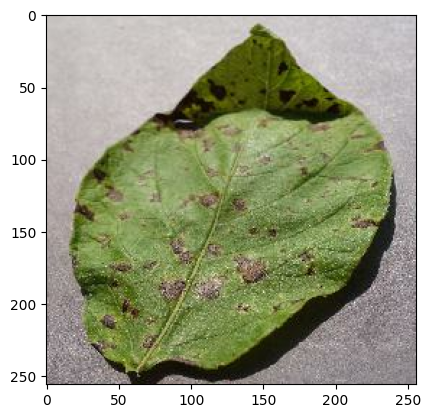

In [40]:
for images_batch, labels_batch in test_df.take(1):
    print('Image to be predicted')
    image=images_batch[0].numpy().astype('uint8')
    label=labels_batch[0].numpy()
    
    p_label=Disease_Classifier.predict(images_batch)
    
    print('First Image')
    plt.imshow(image)
    print('Actual Label : ', classes[label])
    print('Predicted Label : ', classes[np.argmax(p_label[0])])

In [41]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = classes[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 17ms/step


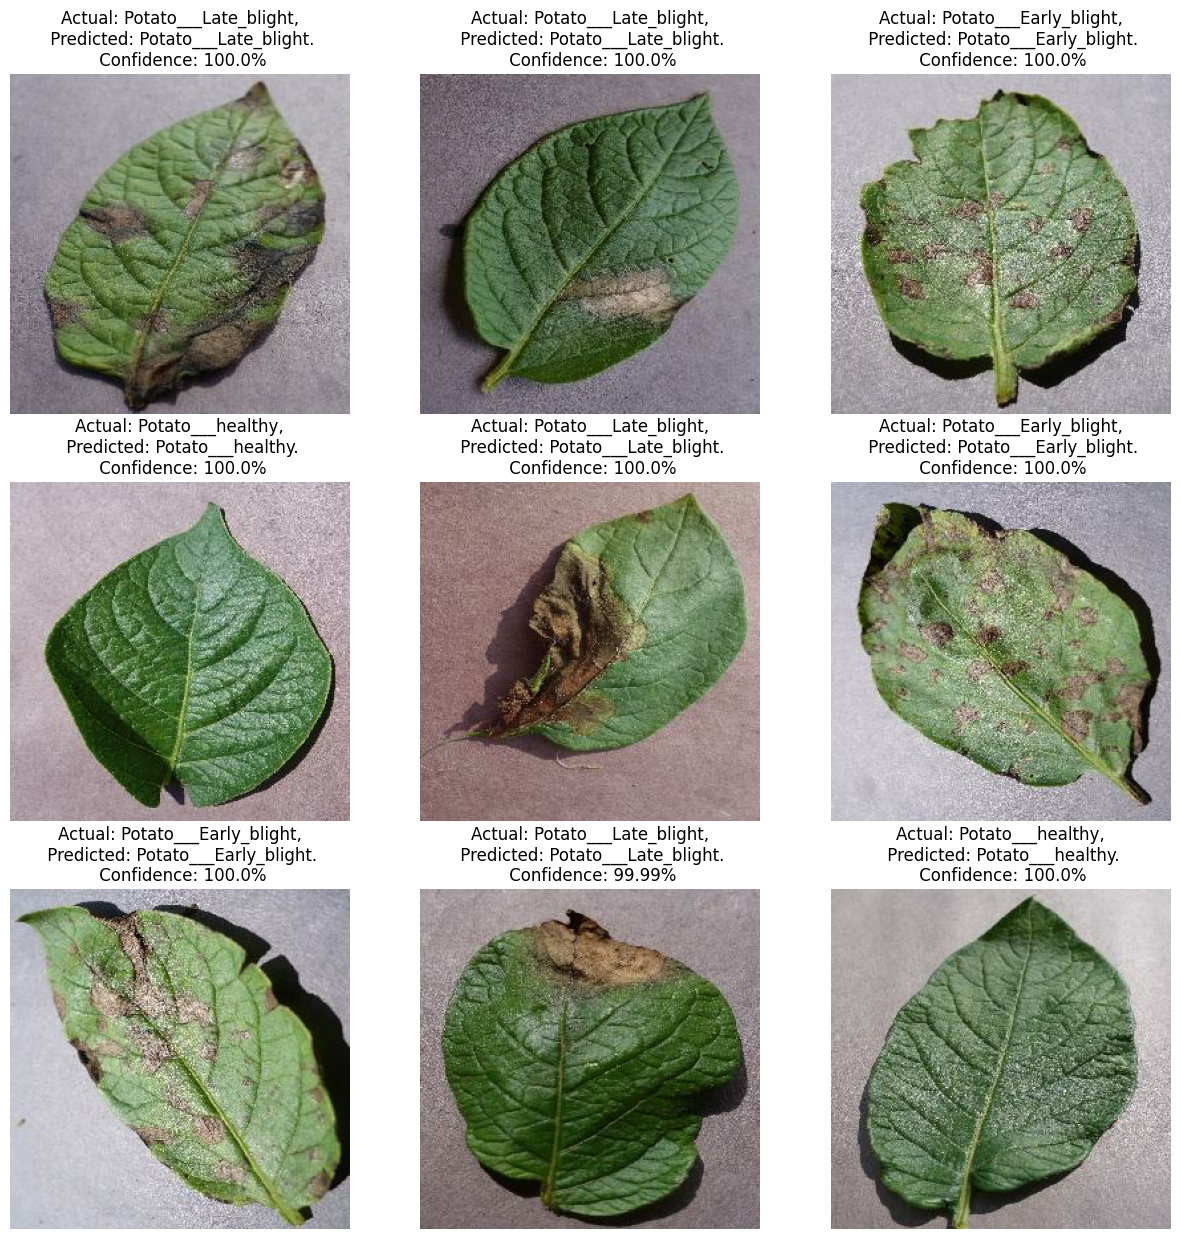

In [42]:
plt.figure(figsize=(15, 15))
for images, labels in test_df.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(Disease_Classifier, images[i].numpy())
        actual_class = classes[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Saving our Model

In [46]:
# Run this cell to save model to disk automatically
import os
model_version=max([int(i) for i in os.listdir('./Models')+[0]])+1
Disease_Classifier.save(f'./Models/{model_version}')

INFO:tensorflow:Assets written to: ./Models/2\assets


INFO:tensorflow:Assets written to: ./Models/2\assets
